In [3]:
import pythetatools.toyxp as toyxp
import pythetatools.likelihood as likelihood
from pythetatools.config import *
from pythetatools.config_visualisation import *

from pythetatools.base_visualisation import show_minor_ticks
from pythetatools.file_manager import read_cont, download
from pythetatools.feldman_cousins import get_critical_values
from collections import defaultdict


import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import uproot
import matplotlib.colors as colors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read MargTemplates and save the dchi2 in hist.root.

In [4]:
# Set the input dir and pattern of your files

dir_ver = 'OA2023'
basedir = f"{inputs_dir}/{dir_ver}/MargTemplates"

indir = f"{basedir}/MargTemplates_DataFit_dm2_100k_p-theta_mode_0"
file_pattern = f"{indir}/marg*.root"

Number of entries in 'MargTemplate': 1640.
Grid sizes: [41] for parameters ['dm2']
Objects written in /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/MargTemplates/MargTemplates_DataFit_dm2_100k_p-theta_mode_0/hist.root
Objects written in /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/MargTemplates/MargTemplates_DataFit_dm2_100k_p-theta_mode_0/hist_IH.root
Histograms saved to ROOT files.


Warning in <TROOT::Append>: Replacing existing TH1: cont (Potential memory leak).


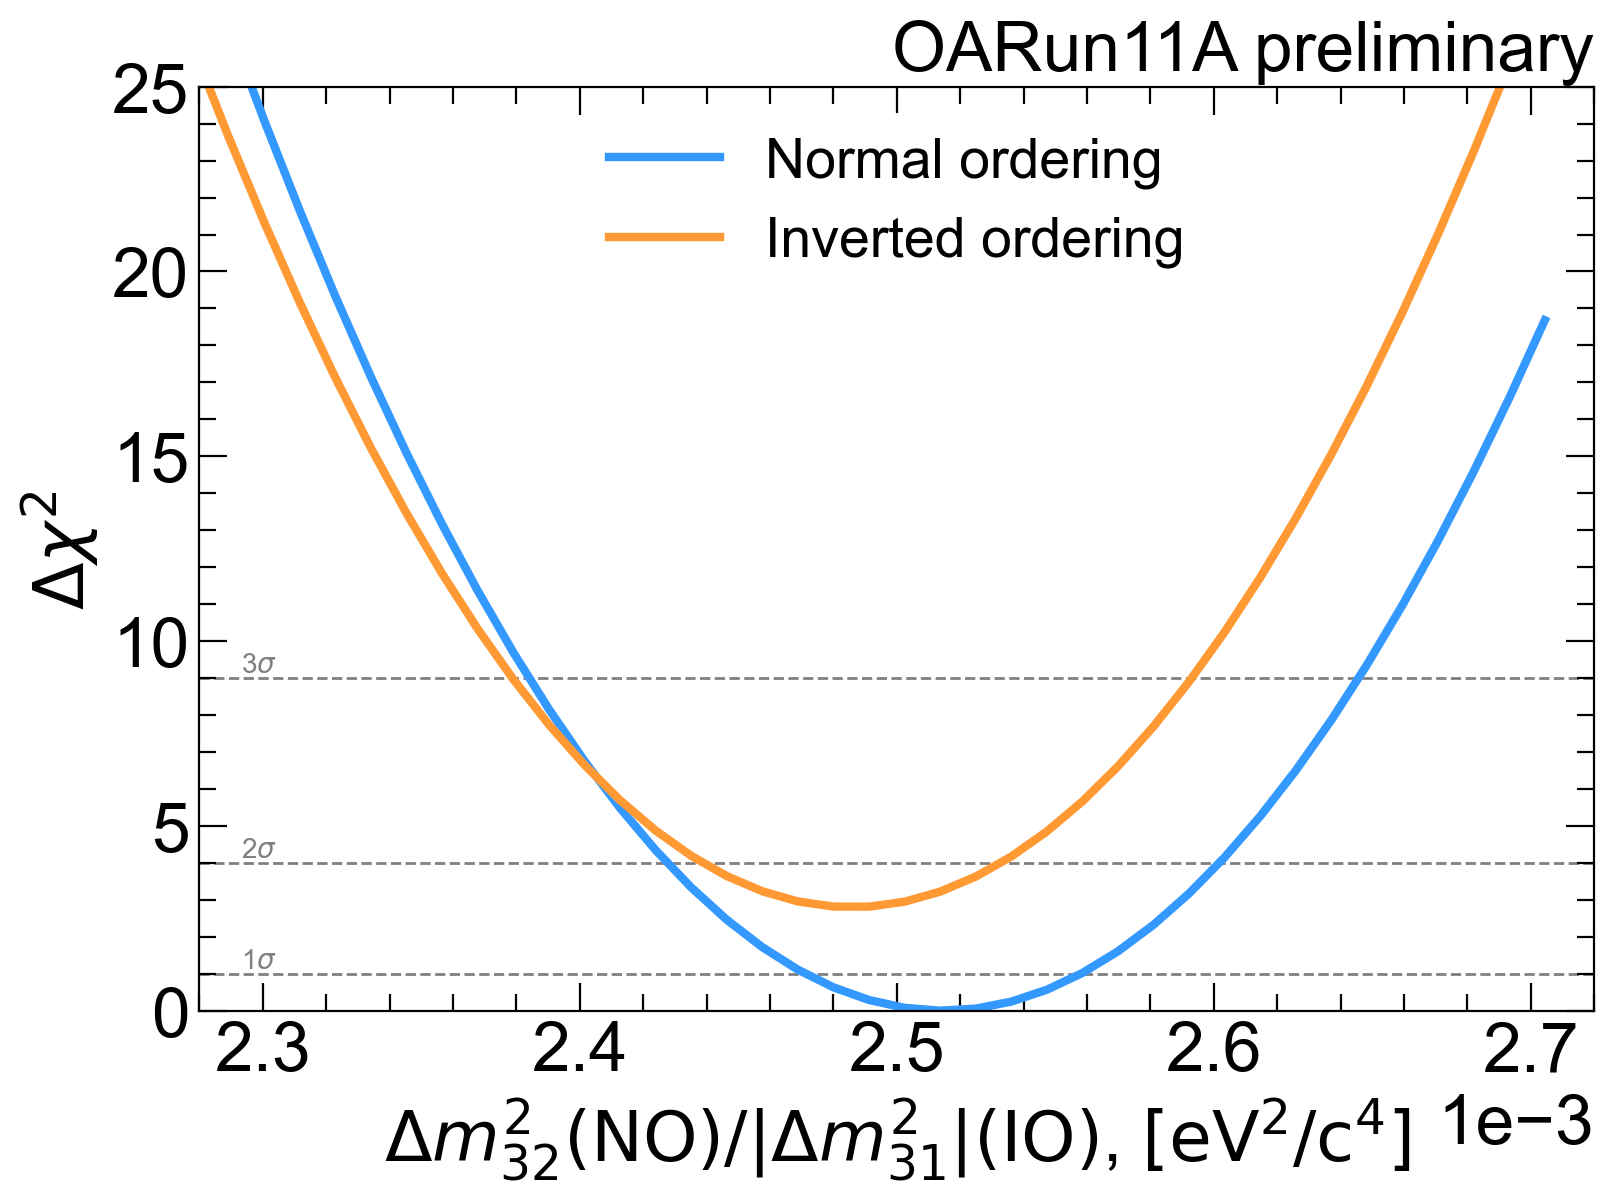

In [5]:
grid, avnllh, param_name = likelihood.load(file_pattern)
llh = likelihood.Loglikelihood(grid, avnllh, param_name, mo_treat='joint')
param_name_x = param_name[0]
grid_x = grid[0]

param_names_flattened =  "".join(param_name)

fig, ax = plt.subplots()

#Plot llh to check what is saved
llh.plot(ax, wtag=True, show_const_critical=True)
likelihood.save_avnll_hist(llh, indir)


# Smear the contours (only for dm2)

TFile**		/Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/MargTemplates/MargTemplates_DataFit_dm2_100k_p-theta_mode_0/hist.root	
 TFile*		/Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/MargTemplates/MargTemplates_DataFit_dm2_100k_p-theta_mode_0/hist.root	
  OBJ: TH1D	cont	cont : 0 at: 0x14fd17b60
  KEY: TH1D	cont;1	cont
  KEY: TParameter<int>	xParam;1	
  KEY: TObjString	xParamName;1	Collectable string class
Original number of bins: x=41
Target number of bins: x=410
0.1
Error in <TClass::LoadClassInfo>: no interpreter information for class TH2 is available even though it has a TClass initialization routine.
Error in <TClass::LoadClassInfo>: no interpreter information for class TH2 is available even though it has a TClass initialization routine.
Error in <TClass::LoadClassInfo>: no interpreter information for class TH2 is available even though it has a TClass initialization routine.
Saved /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/MargTemplates/MargTemp

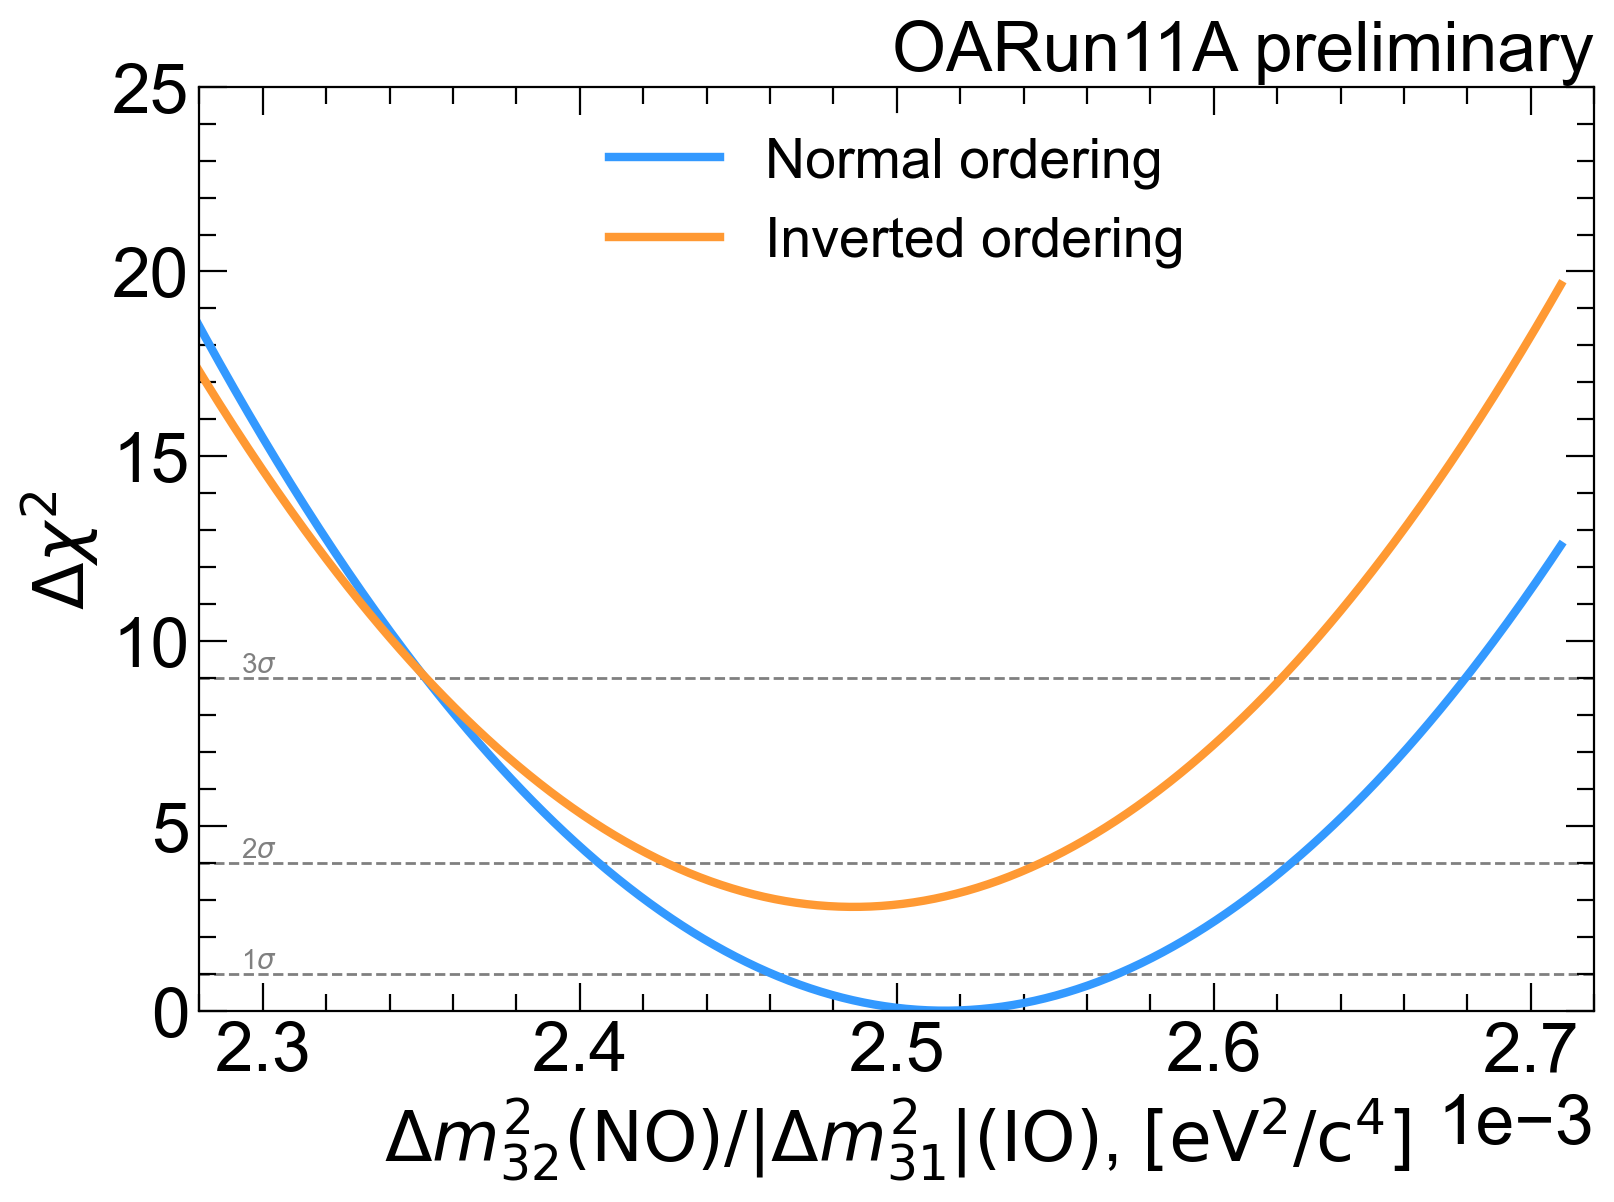

In [7]:
def smear_contour(indir, smear_factor=3.3e-5, compile=False):
    if compile:
        macro_path = "../pythetatools/macros/Smear.C"
        !g++ {macro_path} -o ../build/Smear `root-config --cflags --libs`

    for suf in ['', '_IH']:
        input_file = os.path.join(indir, f'hist{suf}.root')
        output_file = os.path.join(indir, f'hist{suf}_smeared_{smear_factor}.root')
        
        !../build/Smear {input_file} {output_file} {smear_factor}
        print(f'Saved {output_file}')

if 'dm2' in param_name:
    smeared = True
    smear_factor = 3.3e-5
    smear_contour(indir, smear_factor=smear_factor, compile=False)

    mo_to_suffix = {0:'', 1:'_IH'}
    smeared_postfix = {False: '', True: f'_smeared_{smear_factor}'}

    avnllh = {}

    for mo in [0, 1]:
        bin_edges, double_avnllh, param_names = read_cont(os.path.join(indir, f'hist{mo_to_suffix[mo]}{smeared_postfix[smeared]}.root'))
        avnllh[mo] = double_avnllh/2
    grid = [(bin_edges[i][1:]+bin_edges[i][:-1])/2 for i in range(len(bin_edges))]
    llh = likelihood.Loglikelihood(grid, avnllh, param_names, mo_treat='joint')
    
    fig, ax = plt.subplots()
    llh.plot(ax, wtag=True)
    